In [1]:
# Librairies basiques d'exploitation et visualization de données
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import random # Pour pouvoir mélanger notre jeu de données

In [4]:
# Modules pour le pré-processing
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA as ACP
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler, FunctionTransformer
from sklearn.utils import shuffle

# Module pour l'exploration de la projection factorielle
from fanalysis.pca import PCA

# Modèle pour la régression linéaire
from sklearn.linear_model import SGDRegressor

# Module pour l'affichage
from sklearn import set_config
set_config(display="diagram")

# Librairie pour la lecture et enregistrement des modèles
import pickle

In [5]:
import warnings
warnings.filterwarnings("ignore")

# Regression - Avec AFDM pour réduction de la dimensionalité et Régression Stochastique pour jeu de données large

In [6]:
df_train = pd.read_csv("df_sansNantypelocal.csv", sep="\t")

In [7]:
df_train.head()

,Unnamed: 0,Valeur fonciere,Nombre de lots,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,exterieur,year,month,nom_departement,nom_region,pop_active,salaire_moyen,nb_etab_elem
0,0,90000.0,0,Maison,150.0,3,347.0,1.0,2018,1,Ain,Auvergne-Rhône-Alpes,320682.0,15.336249,405
1,11,154200.0,0,Maison,180.0,6,680.0,1.0,2018,6,Ain,Auvergne-Rhône-Alpes,320682.0,15.336249,405
2,13,184000.0,0,Maison,147.0,6,1725.0,1.0,2018,6,Ain,Auvergne-Rhône-Alpes,320682.0,15.336249,405
3,14,300000.0,0,Local,1147.0,0,2693.0,1.0,2018,6,Ain,Auvergne-Rhône-Alpes,320682.0,15.336249,405
4,17,181684.0,0,Maison,97.0,4,1050.0,1.0,2018,7,Ain,Auvergne-Rhône-Alpes,320682.0,15.336249,405


# Gestion des outliers

In [8]:
# On récupère les différents quartiles pour pouvoir enlever les biens avec un prix anormalement hauts comparés aux autres biens.
Q1, Q2, Q3 = df_train['Valeur fonciere'].quantile([0.25, 0.5, 0.75])

# On calcule le rang interquartile
IQR = Q3-Q1

([<matplotlib.patches.Wedge at 0x16fc6f18c50>,
 [Text(-1.078428259607903, 0.2167775100859626, ''),
  Text(1.0784282443857687, -0.2167775858132684, '')],
 [Text(-0.5882335961497652, 0.11824227822870687, '94%'),
  Text(0.5882335878467829, -0.11824231953451, '6%')])

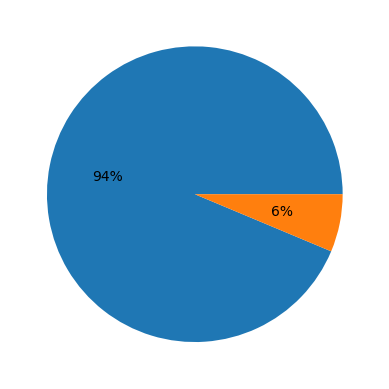

In [9]:
# On détexte les biens ayant un prix supérieur au troisième quartile multiplié par 1.5 fois le rang interquartile
outliers_max = df_train["Valeur fonciere"] > (Q3 + 1.5*(IQR))
plt.pie(outliers_max.value_counts(), autopct='%.0f%%')

In [10]:
df_train = df_train[df_train["Valeur fonciere"] < (Q3 + 1.5*(IQR))]

In [11]:
df_train.drop(columns=["nom_departement", "Unnamed: 0"], inplace=True)
df_train.head()

,Valeur fonciere,Nombre de lots,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,exterieur,year,month,nom_region,pop_active,salaire_moyen,nb_etab_elem
0,90000.0,0,Maison,150.0,3,347.0,1.0,2018,1,Auvergne-Rhône-Alpes,320682.0,15.336249,405
1,154200.0,0,Maison,180.0,6,680.0,1.0,2018,6,Auvergne-Rhône-Alpes,320682.0,15.336249,405
2,184000.0,0,Maison,147.0,6,1725.0,1.0,2018,6,Auvergne-Rhône-Alpes,320682.0,15.336249,405
3,300000.0,0,Local,1147.0,0,2693.0,1.0,2018,6,Auvergne-Rhône-Alpes,320682.0,15.336249,405
4,181684.0,0,Maison,97.0,4,1050.0,1.0,2018,7,Auvergne-Rhône-Alpes,320682.0,15.336249,405


In [12]:
X = df_train.iloc[:,1:]
X.head()

,Nombre de lots,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,exterieur,year,month,nom_region,pop_active,salaire_moyen,nb_etab_elem
0,0,Maison,150.0,3,347.0,1.0,2018,1,Auvergne-Rhône-Alpes,320682.0,15.336249,405
1,0,Maison,180.0,6,680.0,1.0,2018,6,Auvergne-Rhône-Alpes,320682.0,15.336249,405
2,0,Maison,147.0,6,1725.0,1.0,2018,6,Auvergne-Rhône-Alpes,320682.0,15.336249,405
3,0,Local,1147.0,0,2693.0,1.0,2018,6,Auvergne-Rhône-Alpes,320682.0,15.336249,405
4,0,Maison,97.0,4,1050.0,1.0,2018,7,Auvergne-Rhône-Alpes,320682.0,15.336249,405


In [13]:
y = df_train.iloc[:,0]
y.head()

0     90000.0
1    154200.0
2    184000.0
3    300000.0
4    181684.0
Name: Valeur fonciere, dtype: float64

## Création de la pipeline

In [14]:
# Création d'un objet qui imputera les valeurs manquantes de la variable type local 

class DecisionTreeImputer(TransformerMixin):

    def __init__(self, model_path):
        with open(model_path, 'rb') as file:
            self.model = pickle.load(file) # On charge le modèle d'arbre de classification

    # Comme nous chargons le modèle, il n'y a pas de fit
    def fit(self, X, y=None):
        return self

    # Notre transform impute les valeurs manquantes en se basant sur les prédictions de notre arbre de classification.
    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
            
        X_filled = X.copy()
        
        # Pour chaque colonne de notre dataset,
        for column in X_filled.columns:
            # On récupère les indexs des individus ayant une valeur nulle
            missing_indices = X_filled[column].isnull()
            # S'il existe au moins un index avec une valeur manquante
            if missing_indices.any():
                # On utilise la prédiction du modèle pour remplir la valeur.
                predictions = self.model.predict(X_filled[missing_indices].values)
                X_filled.loc[missing_indices, column] = predictions
        
        # On retourne notre dataframe 
        return X_filled.values

In [15]:
class Qual_Standardize(TransformerMixin):

    # On standardize les valeurs qualitatives en utilisant la racine carré de p_k.
    def __init__(self):
        self.p_k = None

    # Notre fit calcule la valeur p_k nécessaire à la transformation.
    def fit(self, X, y=None):
        qual_int = X.astype(int)
        # On calcule la valeur p_k comme la proportion de True dans la colonne
        self.p_k = np.sum(qual_int, axis=0) / qual_int.shape[0]
        return self

    def transform(self, X, y=None):
        qual_int = X.astype(int)    
        # On transforme chaque valeur du tableau disjonctif complet par la racine carré de p_k
        qual_trans = qual_int / (np.sqrt(self.p_k))

        return qual_trans

In [16]:
# On déclare nos variables quantitatives
quant_columns = ['Nombre de lots', 'Surface reelle bati', 'Nombre pieces principales',
       'Surface terrain','month','pop_active',
       'salaire_moyen', 'nb_etab_elem']

# On déclare nos variables quantitatives
cat_columns = [ 'exterieur', 'nom_region']

In [18]:
# On crée une première pipeline qui va centrer et réduire nos variables quantitatives
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)


# On crée une seconde pipeline qui va créer un tableau disjonctif de notre variable qualitative puis la standardiser
categorical_transformer = Pipeline(
    steps=[("disjonctif", OneHotEncoder(handle_unknown="error")),
            ("standardize", Qual_Standardize())

    ]
)

# On crée une troisième pipeline qui va imputer les valeurs manquantes, créer un tableau disjonctif de notre variable type local puis la standardiser
local_transformer = Pipeline(
    steps=[("na_imputer", DecisionTreeImputer(model_path='tree_classif_typelocal.pkl')),
        ("disjonctif", OneHotEncoder(handle_unknown="error")),
        ("standardize", Qual_Standardize())

    ]
)

# On crée un ColumnTransformer qui appliquera nos pipelines selon si elles sont qualitatives, quantitatives ou si c'est "Type local"
preprocessor = ColumnTransformer(
    transformers=[

        ("num", numeric_transformer, quant_columns),
        ("cat", categorical_transformer, cat_columns),
        ('local', local_transformer, ["Type local"])
    ]
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Nombre de lots', 'Surface reelle bati',
                                  'Nombre pieces principales',
                                  'Surface terrain', 'month', 'pop_active',
                                  'salaire_moyen', 'nb_etab_elem']),
                                ('cat',
                                 Pipeline(steps=[('disjonctif',
                                                  OneHotEncoder()),
                                                 ('standardize',
                                                  <__main__.Qual_Standardize object at 0x0000016F82395590>)]),
                                 ['exterieur', 'nom_region']),
                                ('local',
                                 Pipeline(steps=[('na_imputer',
                                                  <__main__.DecisionTreeImputer object at 0x0000016F82395490>),
                                                 ('disjonctif',
                                                  OneHotEncoder()),
                                                 ('standardize',
                                                  <__main__.Qual_Standardize object at 0x0000016F82832190>)]),
                                 ['Type local'])])

In [19]:
# On convertit notre variable extérieur en booléen.
X["exterieur"] = X["exterieur"].astype(bool)

In [20]:
# On divise notre jeu de données en un échantillon d'apprentissage et un test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [21]:
X_train.head()

,Nombre de lots,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,exterieur,year,month,nom_region,pop_active,salaire_moyen,nb_etab_elem
1630726,1,Dépendance,0.0,0,0.0,False,2019,4,Île-de-France,706910.0,16.824866,716
780634,0,Maison,36.0,1,75.0,True,2020,1,Centre-Val de Loire,281632.0,15.225494,312
931316,1,Appartement,105.0,3,0.0,False,2019,7,Pays de la Loire,693553.0,15.831803,634
1082212,1,Dépendance,0.0,0,0.0,False,2020,6,Grand Est,261811.0,15.058448,289
705180,0,Maison,284.0,4,428.0,True,2018,10,Occitanie,522553.0,15.104489,453


In [22]:
y_train.head()

1630726      2000.0
780634     275000.0
931316     285000.0
1082212    260000.0
705180     157500.0
Name: Valeur fonciere, dtype: float64

## Application de notre pipeline

In [23]:
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)

In [24]:
# On récupère les noms de colonnes de notre tableau disjonctif de nos variables qualitatives
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['disjonctif'].get_feature_names_out(cat_columns)
cat_feature_names

array(['exterieur_False', 'exterieur_True',
       'nom_region_Auvergne-Rhône-Alpes',
       'nom_region_Bourgogne-Franche-Comté', 'nom_region_Bretagne',
       'nom_region_Centre-Val de Loire', 'nom_region_Corse',
       'nom_region_Grand Est', 'nom_region_Guadeloupe',
       'nom_region_Guyane', 'nom_region_Hauts-de-France',
       'nom_region_La Réunion', 'nom_region_Martinique',
       'nom_region_Normandie', 'nom_region_Nouvelle-Aquitaine',
       'nom_region_Occitanie', 'nom_region_Pays de la Loire',
       "nom_region_Provence-Alpes-Côte d'Azur",
       'nom_region_Île-de-France'], dtype=object)

In [25]:
# On récupère les noms de colonnes de notre tableau disjonctif de la variable type local
local_feature_names = preprocessor.named_transformers_['local'].named_steps['disjonctif'].get_feature_names_out(input_features=["Type local"])
local_feature_names

array(['Type local_Appartement', 'Type local_Dépendance',
       'Type local_Local', 'Type local_Maison'], dtype=object)

In [26]:
# On crée une liste avec toutes nos variables (dans l'ordre de la pipeline)
all_feature_names = np.concatenate([quant_columns, cat_feature_names,local_feature_names ])

In [27]:
# On transforme notre échantillon d'apprentissage
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_train_preprocessed

,Nombre de lots,Surface reelle bati,Nombre pieces principales,Surface terrain,month,pop_active,salaire_moyen,nb_etab_elem,exterieur_False,exterieur_True,...,nom_region_Normandie,nom_region_Nouvelle-Aquitaine,nom_region_Occitanie,nom_region_Pays de la Loire,nom_region_Provence-Alpes-Côte d'Azur,nom_region_Île-de-France,Type local_Appartement,Type local_Dépendance,Type local_Local,Type local_Maison
0,0.410769,-0.291689,-1.455700,-0.236521,-0.785449,0.682364,0.270225,0.896466,1.483931,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,2.430818,0.000000,2.649448,0.0,0.000000
1,-0.709415,-0.158565,-0.942306,-0.177441,-1.660008,-0.652772,-0.226280,-0.639436,0.000000,1.353481,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.374419
2,0.410769,0.096590,0.084482,-0.236521,0.089109,0.640431,-0.038059,0.584724,1.483931,0.000000,...,0.0,0.000000,0.000000,4.066062,0.000000,0.000000,1.899797,0.000000,0.0,0.000000
3,0.410769,-0.291689,-1.455700,-0.236521,-0.202410,-0.714999,-0.278138,-0.726876,1.483931,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.649448,0.0,0.000000
4,-0.709415,0.758512,0.597877,0.100629,0.963668,0.103586,-0.263845,-0.103391,0.000000,1.353481,...,0.0,0.000000,2.978275,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.374419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424962,0.410769,-0.188148,-0.428912,-0.236521,-0.493930,0.004213,0.129423,-0.369512,1.483931,0.000000,...,0.0,0.000000,0.000000,0.000000,3.349843,0.000000,1.899797,0.000000,0.0,0.000000
1424963,-0.709415,-0.014347,0.597877,0.592175,0.672148,-0.953301,-0.618652,-0.745885,0.000000,1.353481,...,0.0,3.111633,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.374419
1424964,0.410769,-0.021743,0.084482,-0.236521,-0.202410,-0.262705,-0.506088,0.204550,1.483931,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.899797,0.000000,0.0,0.000000
1424965,0.410769,-0.291689,-1.455700,-0.236521,0.380629,-0.262705,-0.506088,0.204550,1.483931,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.649448,0.0,0.000000


## Préparation à la réduction de dimensionalité - Projection factorielle grâce à l'AFDM

In [28]:
# On instantie notre ACP
my_pca = PCA(std_unit=True, row_labels=X_train_preprocessed.index.values, col_labels=X_train_preprocessed.columns.values)
my_pca

PCA(col_labels=array(['Nombre de lots', 'Surface reelle bati',
       'Nombre pieces principales', 'Surface terrain', 'month',
       'pop_active', 'salaire_moyen', 'nb_etab_elem', 'exterieur_False',
       'exterieur_True', 'nom_region_Auvergne-Rhône-Alpes',
       'nom_region_Bourgogne-Franche-Comté', 'nom_region_Bretagne',
       'nom_region_Centre-Val de Loire', 'nom_region_Corse',
       'nom_region_Grand Est...
       'nom_region_La Réunion', 'nom_region_Martinique',
       'nom_region_Normandie', 'nom_region_Nouvelle-Aquitaine',
       'nom_region_Occitanie', 'nom_region_Pays de la Loire',
       "nom_region_Provence-Alpes-Côte d'Azur",
       'nom_region_Île-de-France', 'Type local_Appartement',
       'Type local_Dépendance', 'Type local_Local', 'Type local_Maison'],
      dtype=object),
    row_labels=array([      0,       1,       2, ..., 1424964, 1424965, 1424966],
      dtype=int64))

In [29]:
# On la fait apprendre sur notre échantillon d'apprentissage 
my_pca.fit(X_train_preprocessed.values)
print(my_pca.eig_)

[[5.07501872e+00 2.61447611e+00 1.65167279e+00 1.54070960e+00
  1.33065964e+00 1.12479864e+00 1.11826840e+00 1.09491366e+00
  1.07840933e+00 1.06536595e+00 1.05789245e+00 1.04432760e+00
  1.04275613e+00 1.02751999e+00 1.00854103e+00 1.00346258e+00
  1.00120309e+00 1.00093722e+00 9.94460119e-01 9.80818531e-01
  9.03110512e-01 7.86983540e-01 3.92018569e-01 3.70424191e-01
  2.48670088e-01 2.18800894e-01 1.89671740e-01 3.41088789e-02
  3.06522124e-22 7.38651841e-28 3.11999792e-28]
 [1.63710281e+01 8.43379390e+00 5.32797676e+00 4.97003098e+00
  4.29245046e+00 3.62838272e+00 3.60731742e+00 3.53197955e+00
  3.47873977e+00 3.43666437e+00 3.41255629e+00 3.36879871e+00
  3.36372944e+00 3.31458061e+00 3.25335816e+00 3.23697605e+00
  3.22968740e+00 3.22882974e+00 3.20793587e+00 3.16393074e+00
  2.91325972e+00 2.53865658e+00 1.26457603e+00 1.19491674e+00
  8.02161574e-01 7.05809337e-01 6.11844322e-01 1.10028642e-01
  9.88781044e-22 2.38274787e-27 1.00645094e-27]
 [1.63710281e+01 2.48048220e+01 3.01

In [30]:
eigenvalues = pd.DataFrame({'eigenvalue' : my_pca.eig_[0]}) # Création d'un DataFrame à partir des valeurs propres du modèle AFC.
eigenvalues = eigenvalues.reset_index() # Nous appliquons reset_index() pour récupérer les labels des dimensions pour le diagramme en barres.

# Conversion de la colonne "index" en type catégorie
eigenvalues["index"] = eigenvalues["index"].astype("category")

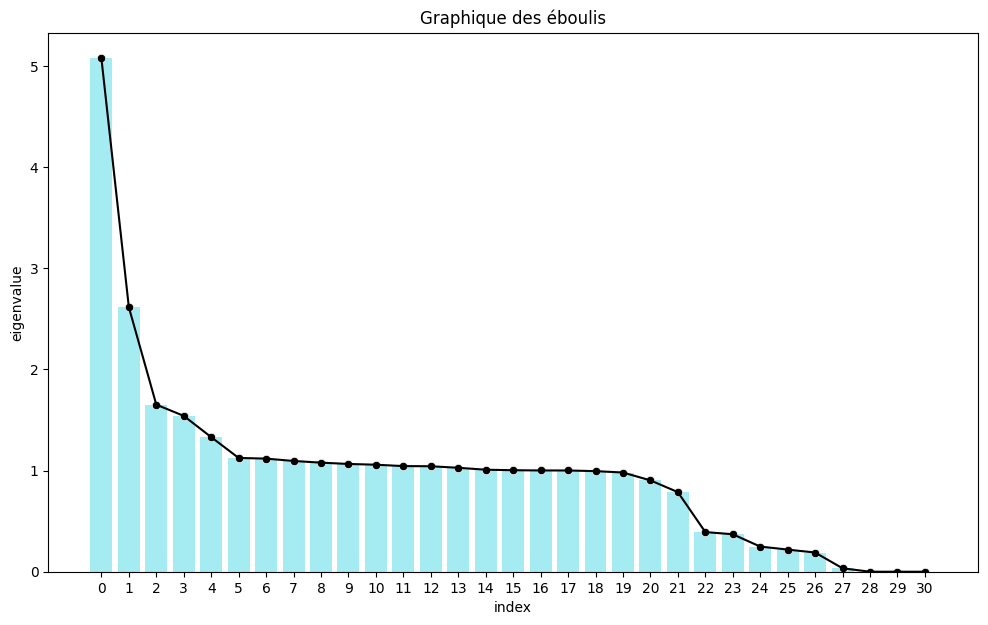

In [31]:
fig, axes = plt.subplots(figsize=(12, 7))
# Création d'un graphique à barres pour les valeurs propres.
sns.barplot(data=eigenvalues, x="index", y="eigenvalue", color="#98F5FF", ax=axes)
# Ajout d'un scatter plot pour les points des valeurs propres.
sns.scatterplot(data=eigenvalues, x="index", y="eigenvalue", color="black", ax=axes)
# Ajout d'une ligne pour connecter les points des valeurs propres.
sns.lineplot(data=eigenvalues, x="index", y="eigenvalue", color="black", ax=axes)
plt.title("Graphique des éboulis")
plt.show()

In [32]:
 # Création d'un DataFrame à partir des pourcentages d'inertie du modèle AFC.
pourcentage = pd.DataFrame({'pourcentage' : my_pca.eig_[1]})
pourcentage = pourcentage.reset_index() # Nous appliquons reset_index() pour récupérer les labels des dimensions pour le diagramme en barres.

pourcentage["index"] = pourcentage["index"].astype("category") # Conversion de la colonne "index" en type catégorie

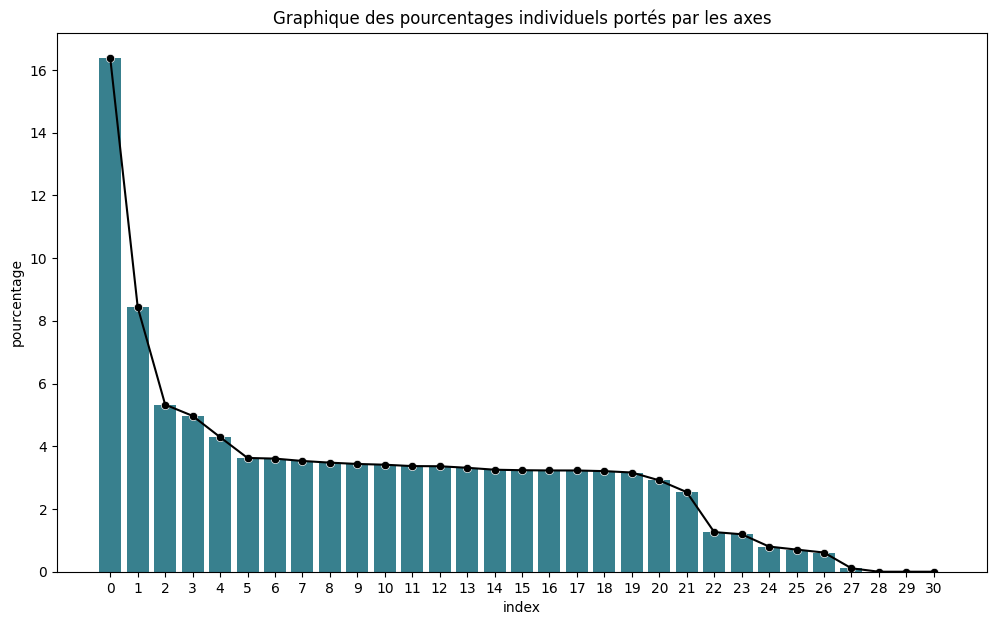

In [33]:
fig, axes = plt.subplots(figsize=(12, 7))
# Création d'un graphique à barres pour représenter les pourcentages.
sns.barplot(data=pourcentage, x="index", y="pourcentage", color="#2a8a9c", ax=axes)
# Création d'un graphique à barres pour représenter les pourcentages.
sns.scatterplot(data=pourcentage, x="index", y="pourcentage", color="black", ax=axes)
# Ajout d'une ligne pour connecter les points des pourcentages.
sns.lineplot(data=pourcentage, x="index", y="pourcentage", color="black", ax=axes)
# On obtient les valeurs minimales et maximales sur l'axe x.
xmin, xmax = axes.get_xlim() 
# On affiche une ligne horizontale qui représente le seuil de Kaiser.
plt.title("Graphique des pourcentages individuels portés par les axes")
plt.show()

In [34]:
cumsum = pd.DataFrame({'cumsum' : my_pca.eig_[2]}) # Création d'un DataFrame à partir des sommes cumulées d'inertie du modèle AFC.
cumsum = cumsum.reset_index() # Nous appliquons reset_index() pour récupérer les labels des dimensions pour le diagramme en barres.
# Conversion de la colonne "index" en type catégorie.
cumsum["index"] = cumsum["index"].astype("category")

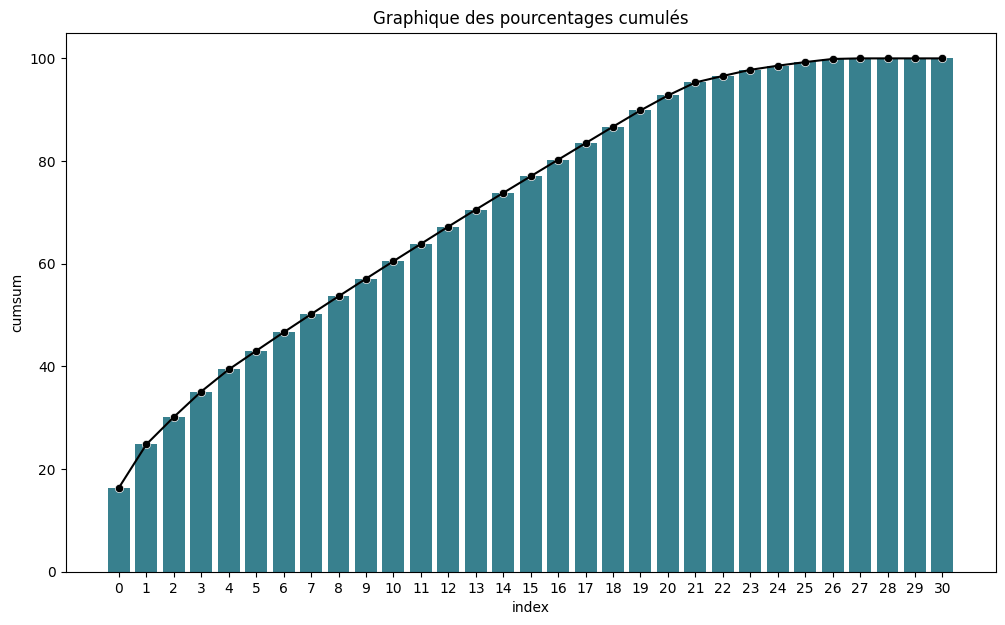

In [35]:
plt.figure(figsize=(12, 7))
# Création d'un graphique à barres pour représenter les pourcentages cumulés.
sns.barplot(data=cumsum, x="index", y="cumsum", color="#2a8a9c")
# Ajout d'un scatter plot pour les points des pourcentages cumulés.
sns.scatterplot(data=cumsum, x="index", y="cumsum", color="black")
# Ajout d'une ligne pour connecter les points des pourcentages cumulés.
sns.lineplot(data=cumsum, x="index", y="cumsum", color="black")
plt.title("Graphique des pourcentages cumulés")
plt.show()

### Information sur la relation entre les variables et les composantes

In [36]:
# On extrait les valeurs en relation avec les variables
df_cols = my_pca.col_topandas()

In [37]:
# On extrait la contribution des variables à la définition des composantes
var_contrib = df_cols.iloc[:,31:37]
var_contrib

,col_contrib_dim1,col_contrib_dim2,col_contrib_dim3,col_contrib_dim4,col_contrib_dim5,col_contrib_dim6
Nombre de lots,12.217879,0.854546,0.800019,4.481451,0.827283,0.010732
Surface reelle bati,0.388653,0.002470,0.037432,0.000262,34.188832,0.626246
Nombre pieces principales,7.580189,1.322340,18.681207,5.789048,0.145301,0.066148
Surface terrain,1.255728,0.004585,0.028904,0.887370,15.406487,0.051163
month,0.015270,0.002334,0.139645,0.056179,0.000096,0.022020
pop_active,3.436070,27.575157,0.003044,0.194400,0.057877,0.128871
salaire_moyen,6.203553,7.038895,8.133499,14.668430,0.294298,0.063049
nb_etab_elem,0.052955,27.759852,5.700324,6.236326,0.014271,0.019802
exterieur_False,17.100546,1.023290,0.019522,1.635433,0.026908,0.002217
exterieur_True,17.100546,1.023290,0.019522,1.635433,0.026908,0.002217


In [38]:
# On extrait la qualité de représentation des variables sur les composantes
var_cos2 = df_cols.iloc[:,62:68]
var_cos2

,col_cos2_dim1,col_cos2_dim2,col_cos2_dim3,col_cos2_dim4,col_cos2_dim5,col_cos2_dim6
Nombre de lots,0.620060,0.022342,0.013214,0.069046,0.011008,0.000121
Surface reelle bati,0.019724,0.000065,0.000618,0.000004,0.454937,0.007044
Nombre pieces principales,0.384696,0.034572,0.308552,0.089192,0.001933,0.000744
Surface terrain,0.063728,0.000120,0.000477,0.013672,0.205008,0.000575
month,0.000775,0.000061,0.002306,0.000866,0.000001,0.000248
pop_active,0.174381,0.720946,0.000050,0.002995,0.000770,0.001450
salaire_moyen,0.314831,0.184030,0.134339,0.225998,0.003916,0.000709
nb_etab_elem,0.002687,0.725775,0.094151,0.096084,0.000190,0.000223
exterieur_False,0.867856,0.026754,0.000322,0.025197,0.000358,0.000025
exterieur_True,0.867856,0.026754,0.000322,0.025197,0.000358,0.000025


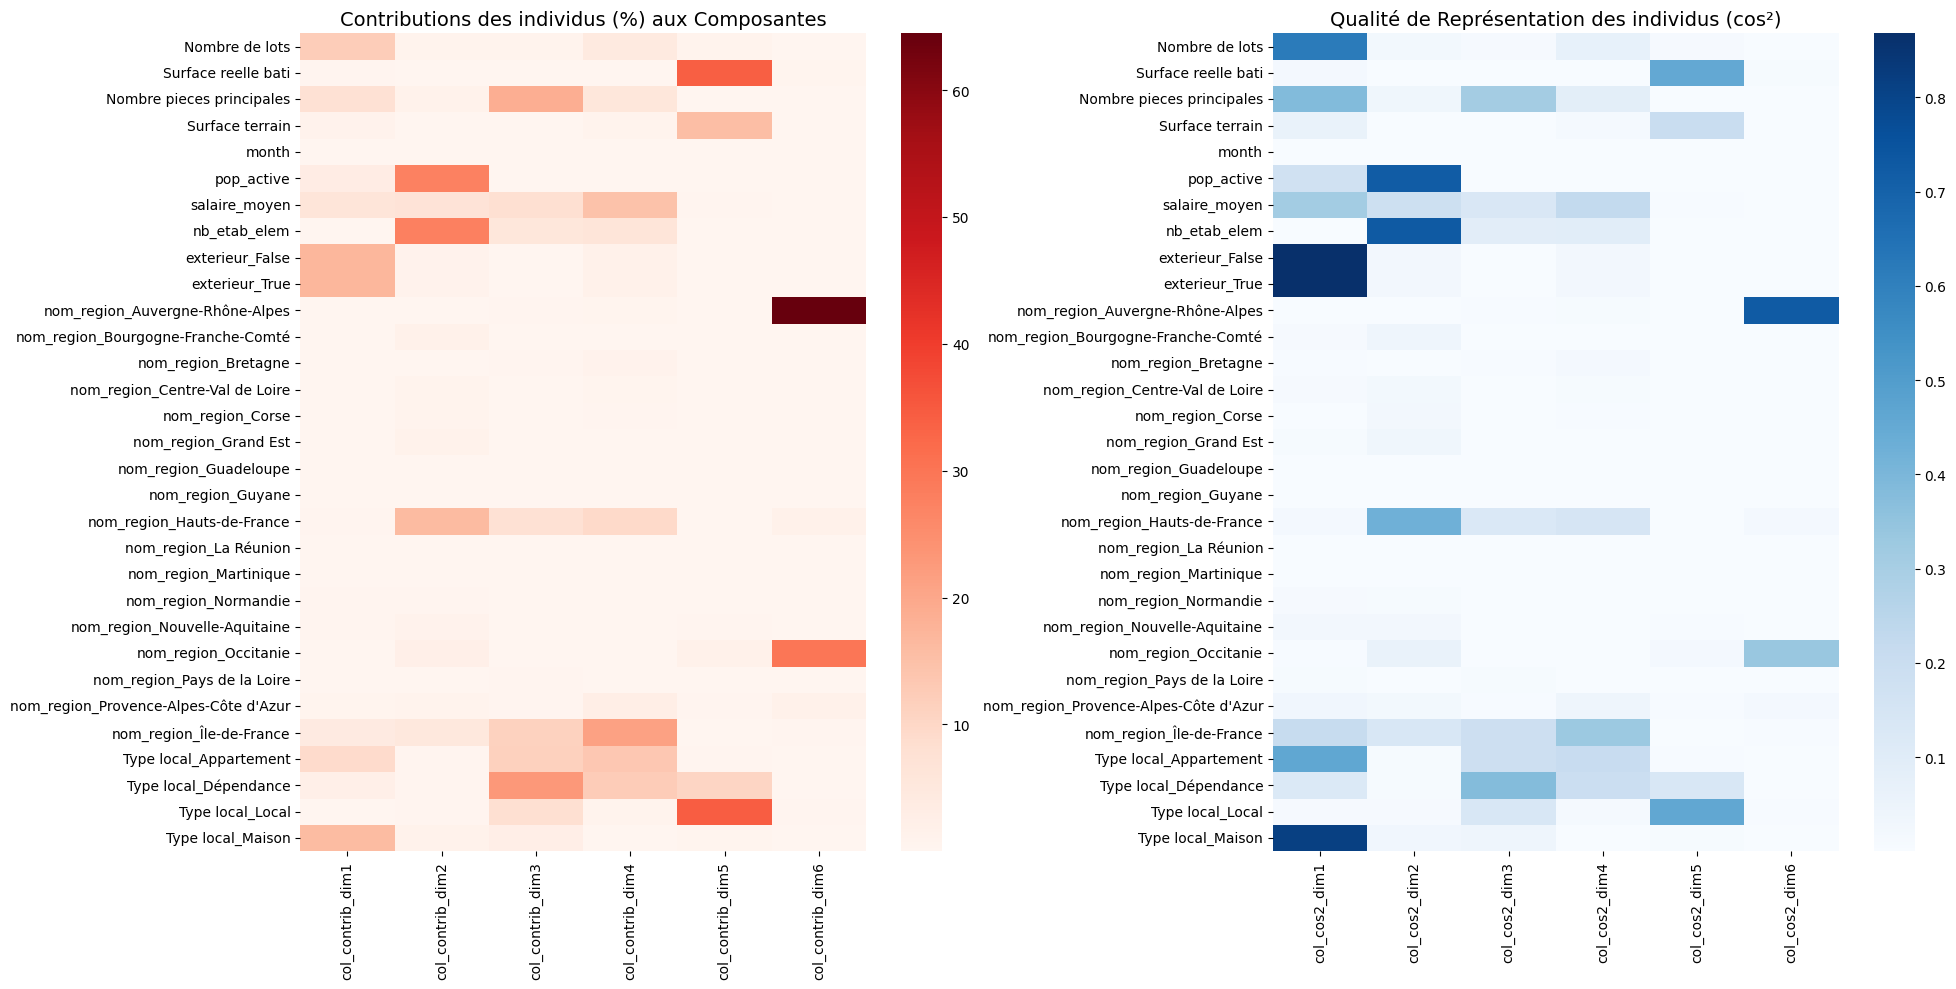

In [39]:
# On visualise les contributions et qualité de représentation grâce à des heatmaps.
fig = plt.figure(figsize=(20, 10))
spec = fig.add_gridspec(ncols=2, nrows=1)

ax0 = fig.add_subplot(spec[0, 0])
sns.heatmap(var_contrib, cmap="Reds", ax=ax0)
ax0.set_title("Contributions des individus (%) aux Composantes", fontsize=14)

ax1 = fig.add_subplot(spec[0, 1])
sns.heatmap(var_cos2, cmap="Blues", ax=ax1)
ax1.set_title("Qualité de Représentation des individus (cos²)", fontsize=14)


plt.tight_layout()
plt.show()

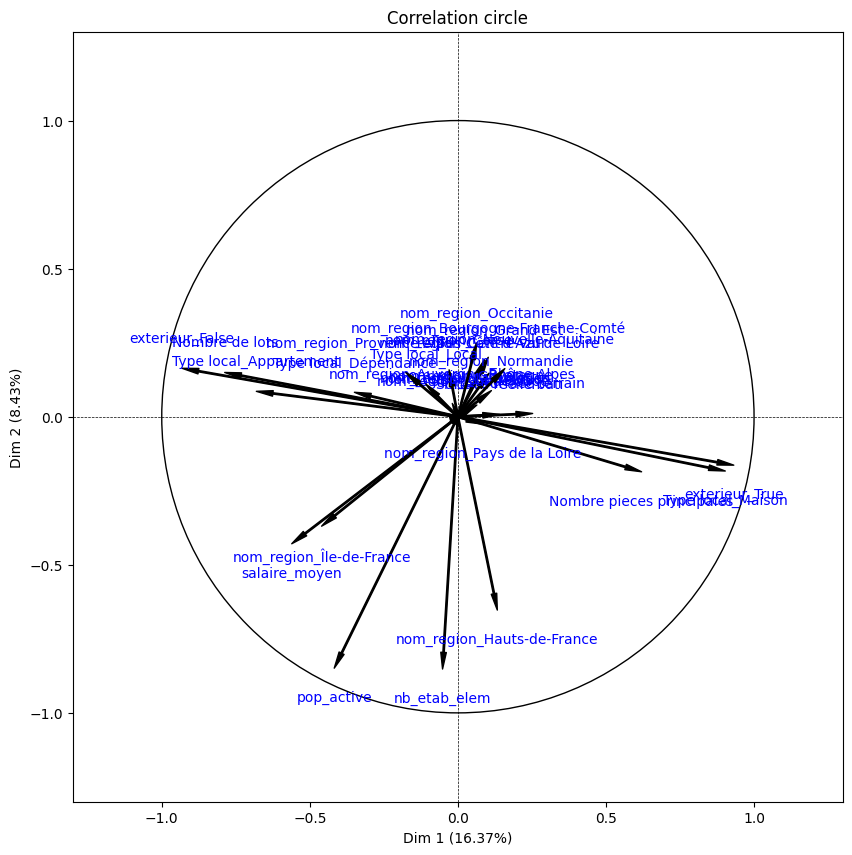

In [40]:
my_pca.correlation_circle(num_x_axis=1, num_y_axis=2, figsize=(20, 10))

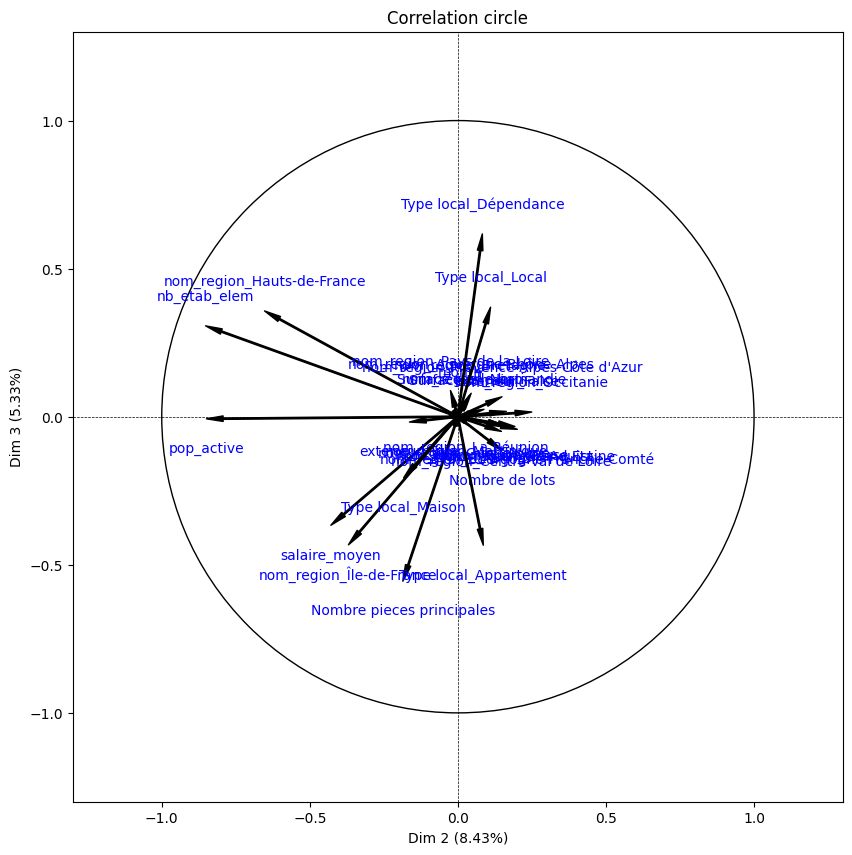

In [41]:
my_pca.correlation_circle(num_x_axis=2, num_y_axis=3, figsize=(20, 10))

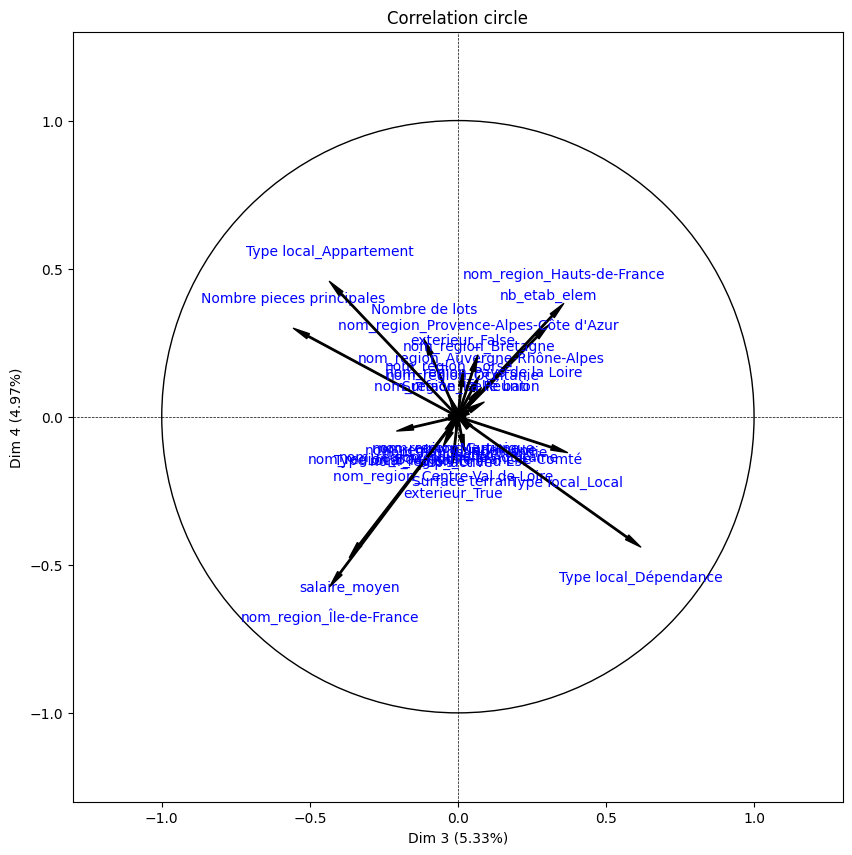

In [42]:
my_pca.correlation_circle(num_x_axis=3, num_y_axis=4, figsize=(20, 10))

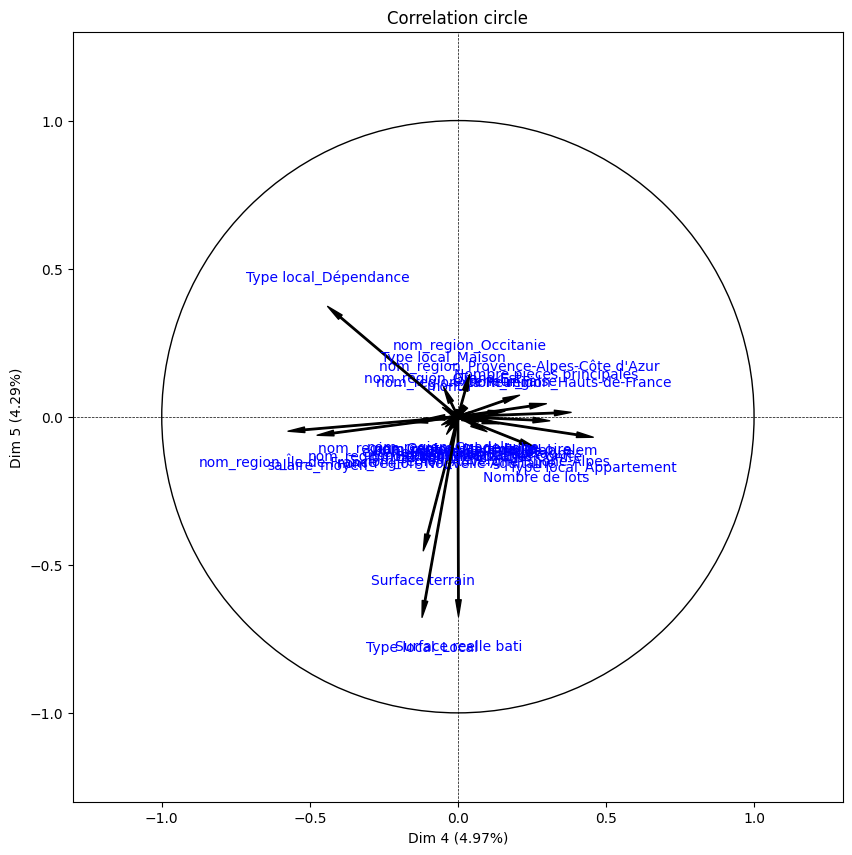

In [43]:
my_pca.correlation_circle(num_x_axis=4, num_y_axis=5, figsize=(20, 10))

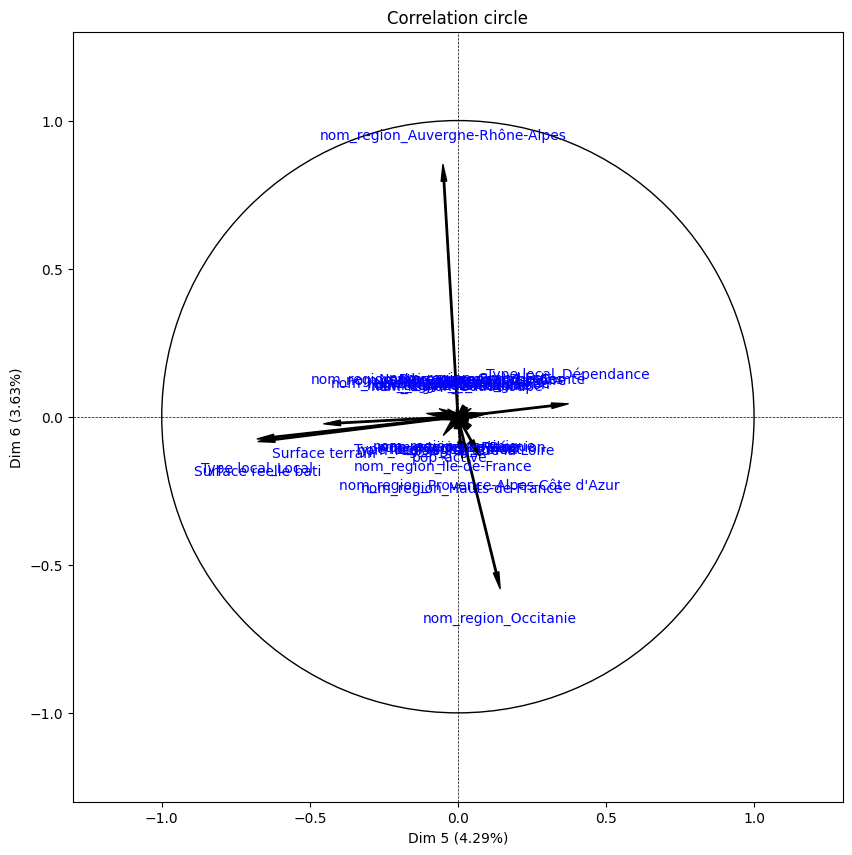

In [44]:
my_pca.correlation_circle(num_x_axis=5, num_y_axis=6, figsize=(20, 10))

### Extraction des coordonnées des invidus pour évaluer la corrélation entre les facteurs et notre variable cible

In [45]:
df_rows = my_pca.row_topandas()

In [46]:
ind_coord = df_rows.iloc[:,0:6]
ind_coord

,row_coord_dim1,row_coord_dim2,row_coord_dim3,row_coord_dim4,row_coord_dim5,row_coord_dim6
0,-2.862528,-0.881693,1.322450,-2.102132,0.925144,-0.075168
1,1.800660,0.944400,-0.121497,-1.142691,0.290705,0.118891
2,-1.841936,-0.267554,-0.231495,1.526857,-0.197656,-0.093355
3,-1.679618,2.056687,1.891211,-1.224453,1.255721,0.247827
4,2.024244,0.084798,-0.272197,-0.180297,0.103325,-1.757591
...,...,...,...,...,...,...
1424962,-2.339390,0.967858,-0.413900,1.563602,0.219132,-0.466225
1424963,2.468936,0.913034,-0.457147,-0.400976,-0.144506,0.081198
1424964,-1.605050,0.689840,-0.263964,1.926930,-0.125299,0.001551
1424965,-1.807523,0.895995,2.546948,-0.294785,1.032581,0.129275


In [47]:
# Pour chaque facteur, on calcule la corrélation
for col in ind_coord.columns:
    coef = np.corrcoef(y_train, ind_coord[col])
    print(coef)

[[1.         0.05929725]
 [0.05929725 1.        ]]
[[ 1.        -0.2686558]
 [-0.2686558  1.       ]]
[[ 1.         -0.32156617]
 [-0.32156617  1.        ]]
[[ 1.         -0.10106914]
 [-0.10106914  1.        ]]
[[ 1.         -0.11957787]
 [-0.11957787  1.        ]]
[[1.         0.01683318]
 [0.01683318 1.        ]]


## On crée notre pipeline qui comprend notre première pipeline de transformation puis qui applique une ACP (pour réaliser une AFDM)

In [48]:
afdm = Pipeline(
    steps=[("preprocessor", preprocessor), ("factorial", ACP(n_components=6))]
)
afdm

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Nombre de lots',
                                                   'Surface reelle bati',
                                                   'Nombre pieces principales',
                                                   'Surface terrain', 'month',
                                                   'pop_active',
                                                   'salaire_moyen',
                                                   'nb_etab_elem']),
                                                 ('cat',
                                                  Pipeline(steps=[('disjonctif',
                                                                   OneHotEncoder()),
                                                                  ('standardize',
                                                                   <__main__.Qual_Standardize object at 0x0000016F82395590>)]),
                                                  ['exterieur', 'nom_region']),
                                                 ('local',
                                                  Pipeline(steps=[('na_imputer',
                                                                   <__main__.DecisionTreeImputer object at 0x0000016F82395490>),
                                                                  ('disjonctif',
                                                                   OneHotEncoder()),
                                                                  ('standardize',
                                                                   <__main__.Qual_Standardize object at 0x0000016F82832190>)]),
                                                  ['Type local'])])),
                ('factorial', PCA(n_components=6))])

In [49]:
# On fait apprendre notre pipeline sur notre échantillon d'apprentissage
X_train_afdm = pd.DataFrame(afdm.fit_transform(X_train))
X_train_afdm.head()


,0,1,2,3,4,5
0,-2.648378,-0.361955,0.820194,1.547987,-1.331459,-0.430769
1,1.446793,0.920582,-0.088176,1.024443,-1.182667,-1.398544
2,-1.221519,-0.297489,0.294553,-1.259093,0.558688,0.255412
3,-0.903727,2.108953,1.068174,1.031734,-0.429327,-0.586080
4,1.593972,-0.189894,-0.147819,0.205259,0.060517,-0.252951


In [50]:
X_train.shape

(1424967, 12)

In [51]:
X_train_afdm.shape

(1424967, 6)

In [52]:
# On transforme notre échantillon test en utilisant les informations tirées de l'échantillon d'apprentissage
X_test_afdm = pd.DataFrame(afdm.transform(X_test))
X_test_afdm.head()

,0,1,2,3,4,5
0,-0.998748,2.728248,2.323153,0.568177,1.822940,-1.093106
1,1.444925,-1.062522,-0.251028,0.220064,-0.139180,-0.624235
2,2.202551,1.059248,-0.366282,0.171980,-0.276311,-0.324498
3,-3.247412,-0.397712,0.110404,2.356613,-1.419730,0.097166
4,1.322424,-0.065905,-0.047429,0.125618,-0.603058,-0.238690


In [53]:
X_test.shape

(701850, 12)

In [54]:
X_test_afdm.shape

(701850, 6)

In [67]:
epoch = 10 # On établit combien de fois notre jeu de données passera entièrement par notre modèle de regression
batch_range = [2**5, 2**6, 2**7, 2**8]
num_samples = len(X_train_afdm) # On décrit la taille de l'échantillon d'apprentissage

In [68]:
d_results = {
    "batch_size":[],
    "mse":[]
}

In [56]:
# On remet l'index de y_train à 0 pour s'aligner avec notre X_train transformée.
y_train= y_train.reset_index().drop(columns=["index"])["Valeur fonciere"]

In [57]:
# On instantie notre modèle
sgd_regressor = SGDRegressor(loss='squared_error', penalty="elasticnet", learning_rate="invscaling", l1_ratio=0.8, shuffle=False)

In [70]:
for batch in batch_range:
    # Pour chaque epoch
    sgd_regressor = SGDRegressor(loss='squared_error', penalty="elasticnet", learning_rate="invscaling", l1_ratio=0.8, shuffle=False)
    for k in range(1,epoch+1):
        # On affiche la progression
        progress = (k/epoch)*100  
        print(f'Progression: Epoch {k}/{epoch} /  {progress}%')  

        # On mélange notre jeu de données 
        X_shuffled, y_shuffled = shuffle(X_train_afdm, y_train)

        # Pour chaque mini-batch, fait apprendre ce groupe de données au modèle grâce au partial_fit
        for i in range(0, num_samples, batch):                    
            X_mini_batch = X_shuffled[i:i+batch]
            y_mini_batch = y_shuffled[i:i+batch]

            # Tant que la taille du batch n'est pas égal à zéro, on continue
            if len(X_mini_batch) > 0:
                sgd_regressor.partial_fit(X_mini_batch, y_mini_batch)
            else:
                break

    # On prédit les valeurs de y pour l'échantillon test
    y_pred = sgd_regressor.predict(X_test_afdm)
    # On extrait la moyenne des résidus au carré
    mse = mean_squared_error(y_test, y_pred)
    # On affiche le socre du modèle.
    print(f"Mean Squared Error: {mse}")

    d_results["batch_size"].append(batch)
    d_results["mse"].append(mse)

Progression: Epoch 1/10 /  10.0%
Progression: Epoch 2/10 /  20.0%
Progression: Epoch 3/10 /  30.0%
Progression: Epoch 4/10 /  40.0%
Progression: Epoch 5/10 /  50.0%
Progression: Epoch 6/10 /  60.0%
Progression: Epoch 7/10 /  70.0%
Progression: Epoch 8/10 /  80.0%
Progression: Epoch 9/10 /  90.0%
Progression: Epoch 10/10 /  100.0%
Mean Squared Error: 9480701400.46998
Progression: Epoch 1/10 /  10.0%
Progression: Epoch 2/10 /  20.0%
Progression: Epoch 3/10 /  30.0%
Progression: Epoch 4/10 /  40.0%
Progression: Epoch 5/10 /  50.0%
Progression: Epoch 6/10 /  60.0%
Progression: Epoch 7/10 /  70.0%
Progression: Epoch 8/10 /  80.0%
Progression: Epoch 9/10 /  90.0%
Progression: Epoch 10/10 /  100.0%
Mean Squared Error: 9457751635.220026
Progression: Epoch 1/10 /  10.0%
Progression: Epoch 2/10 /  20.0%
Progression: Epoch 3/10 /  30.0%
Progression: Epoch 4/10 /  40.0%
Progression: Epoch 5/10 /  50.0%
Progression: Epoch 6/10 /  60.0%
Progression: Epoch 7/10 /  70.0%
Progression: Epoch 8/10 /  80.

In [71]:
d_results

{'batch_size': [32, 64, 128, 256],
 'mse': [9480701400.46998,
  9457751635.220026,
  9469638834.537918,
  9583616495.661535]}

In [59]:
# On calcule les résidus
res = y_test - y_pred

In [60]:
# On crée un dataframe avec nos valeurs prédites, observées et nos résidus.
df_graph = pd.DataFrame({'predicted':  y_pred,
              'observed': y_test,
              'residual': res})

df_graph

,predicted,observed,residual
1423383,69860.539369,35000.0,-34860.539369
1587230,189810.438048,94000.0,-95810.438048
1760389,154756.608335,76923.0,-77833.608335
1677014,170089.568427,224500.0,54410.431573
686679,160990.754727,56000.0,-104990.754727
...,...,...,...
306420,175034.492598,188000.0,12965.507402
1259747,121990.468900,195000.0,73009.531100
145628,155399.003896,55200.0,-100199.003896
286175,78225.753464,155300.0,77074.246536


In [61]:
# On calcule les coefficients et la constante du modèle linéaire.
print("Intercept:", sgd_regressor.intercept_)
print("Coefficients:", sgd_regressor.coef_)

Intercept: [163540.44901205]
Coefficients: [   994.90415426 -17903.89569403 -28670.96571007   9205.50426653
  11378.15877664   2932.00972561]


<Axes: xlabel='predicted', ylabel='observed'>

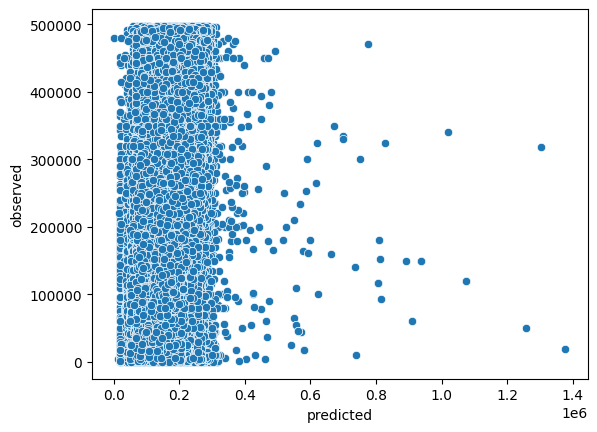

In [62]:
# On crée un nuage de points entre nos valeurs prédites et observées.
sns.scatterplot(x="predicted",y="observed", data=df_graph)